In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
#importing requisite libraries
import pandas as pd
import numpy as np
import zipfile
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import re
from wordcloud import WordCloud
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from datetime import datetime, date
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import coo_matrix
from scipy.sparse import hstack
from scipy.sparse import vstack
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
import pickle
import joblib

In [3]:
train=pd.read_csv("/content/drive/MyDrive/train_users_2.csv")  #reading training data
print(train.shape)
train.head(5)

(213451, 16)


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [4]:
session = pd.read_csv("/content/drive/MyDrive/sessions.csv")   #reading session data

print(session.shape)

print("\nColumns:",session.columns)

session.head()


(10567737, 6)

Columns: Index(['user_id', 'action', 'action_type', 'action_detail', 'device_type',
       'secs_elapsed'],
      dtype='object')


,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [5]:
#Now let's see our test data
test = pd.read_csv('/content/drive/MyDrive/test_users.csv')

print(test.shape)

print(test.columns)

test.head()

(62096, 15)
Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser'],
      dtype='object')


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [ ]:
#Checking null values
test.isnull().sum()

id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking         62096
gender                         0
age                        28876
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked       20
signup_app                     0
first_device_type              0
first_browser                  0
dtype: int64

**We will replace NAN value for age with mode.**

In [6]:
train.loc[train['age']>94,'age']=np.nan
train.loc[train['age']<18,'age']=np.nan       #Since minors won't be booking
train.loc[train['age'].isnull(),'age']=27

In [7]:
session['action'].fillna(session['action'].mode()[0], inplace=True)
session['action_type'].fillna(session['action_type'].mode()[0], inplace=True)
session['action_detail'].fillna(session['action_detail'].mode()[0], inplace=True)
session['device_type'].fillna(session['device_type'].mode()[0], inplace=True)
session['secs_elapsed'].fillna(0, inplace=True)

#replacing space with _ in device_type
session.device_type = session.device_type.str.replace(' ',"_")
print(session.shape)

(10567737, 6)


In [8]:
session = session[pd.isnull(session.user_id) == False]
session.shape

(10533241, 6)

In [9]:
session['action']   = [" "+i+" " for i in session['action']]
session['action_type']   = [" "+i+" " for i in session['action_type']]
session['action_detail']   = [" "+i+" " for i in session['action_detail']]
user_id=list(set(session['user_id'].values))
len(user_id)

135483

In [10]:
sec_e= session.groupby('user_id', sort = False)[['secs_elapsed']].mean()
#Getting one row for one user_id
action = session.groupby('user_id', sort = False)[['action']].sum()
action_type = session.groupby('user_id', sort = False)[['action_type']].sum()
action_detail = session.groupby('user_id', sort = False)[['action_detail']].sum()

In [11]:
new_session=pd.DataFrame(user_id,columns=['user_id'])
new_session['action']=action['action'].values
new_session['action_type']=action_type['action_type'].values
new_session['action_detail']=action_detail['action_detail'].values
new_session['secs_elapsed']=sec_e['secs_elapsed'].values
new_session.head()

,user_id,action,action_type,action_detail,secs_elapsed
0,byvo9nf5vp,lookup search_results lookup search_result...,view click view click view click view ...,view_search_results view_search_results vie...,26988.417323
1,v0k31y55gx,dashboard create confirm_email show show_...,view submit click view data view data ...,dashboard create_user confirm_email_link p...,23093.555556
2,2wpzzhfzhk,verify create show pending requested hea...,-unknown- submit message_post booking_requ...,-unknown- create_user message_post pending...,70965.250000
3,hmdd8luf90,lookup show search_results search_results ...,view view click click view view click ...,view_search_results p3 view_search_results ...,24704.605263
4,rb9cc1pei7,campaigns active create notifications lis...,-unknown- -unknown- -unknown- -unknown- -...,-unknown- -unknown- -unknown- -unknown- -...,319.375000


***Renaming id to user_id so that we can join train and session***

In [12]:
train.rename(columns={"id": "user_id"},inplace='True')
train.head(2)

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,27.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF


***Preprocessing text features ***

In [13]:
train['first_device_type'] = [ str(s).replace(' ', "_") for s in train.first_device_type]
train['affiliate_channel'] = [ str(s).replace('-', "_") for s in train.affiliate_channel]
train['affiliate_provider'] = [ str(s).replace('-', "_") for s in train.affiliate_provider]
train['first_device_type'] = [ str(s).replace('/', "_") for s in train.first_device_type]
train['first_device_type'] = [ str(s).replace('(', "") for s in train.first_device_type]
train['first_device_type'] = [ str(s).replace(')', "") for s in train.first_device_type]
train['first_browser'] = [ str(s).replace('-', "") for s in train.first_browser]
train['first_browser'] = [ str(s).replace(' ', "_") for s in train.first_browser]
train['first_browser'] = [ str(s).replace('.', "_") for s in train.first_browser]
train['gender'] = [ str(s).replace('-', "") for s in train.gender]
train.head()

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,unknown,27.0,facebook,0,en,direct,direct,untracked,Web,Mac_Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac_Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows_Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac_Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,unknown,41.0,basic,0,en,direct,direct,untracked,Web,Mac_Desktop,Chrome,US


***Performing join on train and session on user_id***

In [14]:
train=train.set_index('user_id').join(new_session.set_index('user_id'),how='inner',on='user_id').reset_index()
train.head()

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,action,action_type,action_detail,secs_elapsed
0,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem_non_brand,google,omg,Web,Windows_Desktop,Chrome,other,authenticate header_userpic create verify ...,submit data submit -unknown- message_post...,login header_userpic create_phone_numbers ...,59518.884615
1,yo8nz8bqcq,2014-01-01,20140101001558,NaN,unknown,27.0,basic,0,en,direct,direct,untracked,Web,Mac_Desktop,Firefox,NDF,show personalize show similar_listings pe...,view data view data data view click vi...,p3 wishlist_content_update view_search_resu...,4203.075000
2,4grx6yxeby,2014-01-01,20140101001639,NaN,unknown,27.0,basic,0,en,sem_brand,google,omg,Web,Windows_Desktop,Firefox,NDF,show personalize create header_userpic sh...,view data submit data view click data,view_search_results wishlist_content_update ...,12731.571429
3,ncf87guaf0,2014-01-01,20140101002146,NaN,unknown,27.0,basic,0,en,direct,direct,linked,Web,Windows_Desktop,Chrome,NDF,update index update update update update...,submit view submit submit submit submit ...,update_listing your_listings update_listing...,17418.967033
4,4rvqpxoh3h,2014-01-01,20140101002619,2014-01-02,unknown,27.0,basic,25,en,direct,direct,untracked,iOS,iPhone,unknown,GB,confirm_email create impressions header_us...,click submit view data,confirm_email_link create_user p4 header_u...,171466.500000


**The time we have is in different formats, so we split it into day, month and year. E.g like 2014-
04-01 in date account created and date first booking, while 20140401000102 in timestamp first active. Although, we can use Encoding to translate these time value into distinct numbers, it will introduce a huge range of value while each value only contributes to a limited number of samples. Therefore,
we decide to split the original time value into 3 different features: year, month and day. This process could cause overfitting because of increasing the number of features, but we can use feature selection to address this problem.**

In [16]:
train['account_created_day'] = pd.DatetimeIndex(train['date_account_created']).day
train['account_created_month'] = pd.DatetimeIndex(train['date_account_created']).month
train['account_created_year'] = pd.DatetimeIndex(train['date_account_created']).year
train['first_booking_day'] = pd.DatetimeIndex(train['date_first_booking']).day
train['first_booking_month'] = pd.DatetimeIndex(train['date_first_booking']).month
train['first_booking_year'] = pd.DatetimeIndex(train['date_first_booking']).year
train.head(2)


,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,action,action_type,action_detail,secs_elapsed,account_created_day,account_created_month,first_booking_day,first_booking_month,account_created_year,first_booking_year
0,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem_non_brand,...,authenticate header_userpic create verify ...,submit data submit -unknown- message_post...,login header_userpic create_phone_numbers ...,59518.884615,1,1,4.0,1.0,2014,2014.0
1,yo8nz8bqcq,2014-01-01,20140101001558,NaN,unknown,27.0,basic,0,en,direct,...,show personalize show similar_listings pe...,view data view data data view click vi...,p3 wishlist_content_update view_search_resu...,4203.075000,1,1,NaN,NaN,2014,NaN


***Using variance threshold to remove features with low variance***

In [17]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=1)

In [18]:
#getting all numerical features
train_num = train.select_dtypes(include='number')
train_num.shape

(73815, 10)

In [19]:
_ = vt.fit(train_num)                       #https://towardsdatascience.com/how-to-use-variance-thresholding-for-robust-feature-selection-a4503f2b5c3f

# Get the boolean mask
mask = vt.get_support()

train_reduced = train_num.loc[:, mask]
train_reduced.shape

(73815, 8)

In [20]:
train_num.columns

Index(['timestamp_first_active', 'age', 'signup_flow', 'secs_elapsed',
       'account_created_day', 'account_created_month', 'first_booking_day',
       'first_booking_month', 'account_created_year', 'first_booking_year'],
      dtype='object')

In [21]:
train_reduced.columns

Index(['timestamp_first_active', 'age', 'signup_flow', 'secs_elapsed',
       'account_created_day', 'account_created_month', 'first_booking_day',
       'first_booking_month'],
      dtype='object')

***So we drop year columns for booking and account created since they have low variance.***

In [22]:
train=train.drop(['date_account_created', 'timestamp_first_active','date_first_booking','first_affiliate_tracked','first_booking_year','account_created_year'], axis=1)
train.head()

,user_id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,signup_app,first_device_type,first_browser,country_destination,action,action_type,action_detail,secs_elapsed,account_created_day,account_created_month,first_booking_day,first_booking_month
0,d1mm9tcy42,MALE,62.0,basic,0,en,sem_non_brand,google,Web,Windows_Desktop,Chrome,other,authenticate header_userpic create verify ...,submit data submit -unknown- message_post...,login header_userpic create_phone_numbers ...,59518.884615,1,1,4.0,1.0
1,yo8nz8bqcq,unknown,27.0,basic,0,en,direct,direct,Web,Mac_Desktop,Firefox,NDF,show personalize show similar_listings pe...,view data view data data view click vi...,p3 wishlist_content_update view_search_resu...,4203.075000,1,1,NaN,NaN
2,4grx6yxeby,unknown,27.0,basic,0,en,sem_brand,google,Web,Windows_Desktop,Firefox,NDF,show personalize create header_userpic sh...,view data submit data view click data,view_search_results wishlist_content_update ...,12731.571429,1,1,NaN,NaN
3,ncf87guaf0,unknown,27.0,basic,0,en,direct,direct,Web,Windows_Desktop,Chrome,NDF,update index update update update update...,submit view submit submit submit submit ...,update_listing your_listings update_listing...,17418.967033,1,1,NaN,NaN
4,4rvqpxoh3h,unknown,27.0,basic,25,en,direct,direct,iOS,iPhone,unknown,GB,confirm_email create impressions header_us...,click submit view data,confirm_email_link create_user p4 header_u...,171466.500000,1,1,2.0,1.0


In [ ]:
train['first_booking_day'].isnull().values.any()

True

In [23]:
train['first_booking_day'].fillna(0, inplace=True)
train['first_booking_month'].fillna(0,inplace=True)

In [25]:
test=pd.read_csv('/content/drive/MyDrive/test_users.csv')
test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [26]:
test['account_created_day'] = pd.DatetimeIndex(test['date_account_created']).day
test['account_created_month'] = pd.DatetimeIndex(test['date_account_created']).month
test['first_booking_day'] = pd.DatetimeIndex(test['date_first_booking']).day
test['first_booking_month'] = pd.DatetimeIndex(test['date_first_booking']).month
test.head(2)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,account_created_day,account_created_month,first_booking_day,first_booking_month
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari,1,7,NaN,NaN
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari,1,7,NaN,NaN


In [28]:
test['first_device_type'] = [ s.replace(' ', "_") for s in test.first_device_type]
test['affiliate_channel'] = [ s.replace('-', "_") for s in test.affiliate_channel]
test['affiliate_provider'] = [ s.replace('-', "_") for s in test.affiliate_provider]
test['first_device_type'] = [ s.replace('/', "_") for s in test.first_device_type]
test['first_device_type'] = [ s.replace('(', "") for s in test.first_device_type]
test['first_device_type'] = [ s.replace(')', "") for s in test.first_device_type]
test['first_browser'] = [ s.replace('-', "") for s in test.first_browser]
test['first_browser'] = [ s.replace(' ', "_") for s in test.first_browser]
test['first_browser'] = [ s.replace('.', "_") for s in test.first_browser]
test['gender'] = [ s.replace('-', "") for s in test.gender]
test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,account_created_day,account_created_month,first_booking_day,first_booking_month
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile_Safari,1,7,NaN,NaN
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,unknown,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile_Safari,1,7,NaN,NaN
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,unknown,NaN,basic,0,en,direct,direct,linked,Web,Windows_Desktop,Chrome,1,7,NaN,NaN
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,unknown,NaN,basic,0,en,direct,direct,linked,Web,Windows_Desktop,IE,1,7,NaN,NaN
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,unknown,NaN,basic,0,en,direct,direct,untracked,Web,Mac_Desktop,Safari,1,7,NaN,NaN


In [29]:
test=test.drop(['date_account_created', 'timestamp_first_active','date_first_booking','first_affiliate_tracked'], axis=1)
test.head()

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,signup_app,first_device_type,first_browser,account_created_day,account_created_month,first_booking_day,first_booking_month
0,5uwns89zht,FEMALE,35.0,facebook,0,en,direct,direct,Moweb,iPhone,Mobile_Safari,1,7,NaN,NaN
1,jtl0dijy2j,unknown,NaN,basic,0,en,direct,direct,Moweb,iPhone,Mobile_Safari,1,7,NaN,NaN
2,xx0ulgorjt,unknown,NaN,basic,0,en,direct,direct,Web,Windows_Desktop,Chrome,1,7,NaN,NaN
3,6c6puo6ix0,unknown,NaN,basic,0,en,direct,direct,Web,Windows_Desktop,IE,1,7,NaN,NaN
4,czqhjk3yfe,unknown,NaN,basic,0,en,direct,direct,Web,Mac_Desktop,Safari,1,7,NaN,NaN


In [30]:
test.rename(columns={"id": "user_id"},inplace='True')
test.head(2)

,user_id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,signup_app,first_device_type,first_browser,account_created_day,account_created_month,first_booking_day,first_booking_month
0,5uwns89zht,FEMALE,35.0,facebook,0,en,direct,direct,Moweb,iPhone,Mobile_Safari,1,7,NaN,NaN
1,jtl0dijy2j,unknown,NaN,basic,0,en,direct,direct,Moweb,iPhone,Mobile_Safari,1,7,NaN,NaN


In [31]:
test=test.set_index('user_id').join(new_session.set_index('user_id'),how='inner',on='user_id').reset_index()
test.head()

,user_id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,signup_app,first_device_type,first_browser,account_created_day,account_created_month,first_booking_day,first_booking_month,action,action_type,action_detail,secs_elapsed
0,5uwns89zht,FEMALE,35.0,facebook,0,en,direct,direct,Moweb,iPhone,Mobile_Safari,1,7,NaN,NaN,cancellation_policies cancellation_policies ...,view view click view view click view s...,cancellation_policies cancellation_policies ...,25133.043478
1,jtl0dijy2j,unknown,NaN,basic,0,en,direct,direct,Moweb,iPhone,Mobile_Safari,1,7,NaN,NaN,social_connections show show update show ...,data view view submit view view click ...,user_social_connections user_profile user_p...,7104.222222
2,xx0ulgorjt,unknown,NaN,basic,0,en,direct,direct,Web,Windows_Desktop,Chrome,1,7,NaN,NaN,index show personalize similar_listings s...,view view data data view view click da...,view_search_results p3 wishlist_content_upd...,57038.421053
3,6c6puo6ix0,unknown,NaN,basic,0,en,direct,direct,Web,Windows_Desktop,IE,1,7,NaN,NaN,header_userpic dashboard header_userpic au...,data view data submit -unknown- view,header_userpic dashboard header_userpic lo...,163558.500000
4,czqhjk3yfe,unknown,NaN,basic,0,en,direct,direct,Web,Mac_Desktop,Safari,1,7,NaN,NaN,search_results search_results lookup searc...,click click view click view click view ...,view_search_results view_search_results vie...,11338.274566


In [32]:
test.loc[test['age'] > 95, 'age'] = np.nan
test.loc[test['age'] < 18, 'age'] = np.nan
test.loc[test['age'].isnull(), 'age' ] = train['age'].mode()
# handling null values in first_booking_day and first_booking_month

test['first_booking_day'].fillna(0, inplace=True)
test['first_booking_month'].fillna(0,inplace=True)

In [33]:
y = train['country_destination'].values
X= train.drop(['country_destination'], axis=1)
X.head(1)

,user_id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,signup_app,first_device_type,first_browser,action,action_type,action_detail,secs_elapsed,account_created_day,account_created_month,first_booking_day,first_booking_month
0,d1mm9tcy42,MALE,62.0,basic,0,en,sem_non_brand,google,Web,Windows_Desktop,Chrome,authenticate header_userpic create verify ...,submit data submit -unknown- message_post...,login header_userpic create_phone_numbers ...,59518.884615,1,1,4.0,1.0


***Vectorizing Text features***

In [34]:
vectorizer_action = TfidfVectorizer(min_df=10,max_features=1000,ngram_range=(1,4))

vectorizer_action.fit(X['action'].values)

train_merge_action_tfidf = vectorizer_action.transform(train['action'].values)

test_merge_action_tfidf = vectorizer_action.transform(test['action'].values)

print("After vectorizations")
print(train_merge_action_tfidf.shape)
print(test_merge_action_tfidf.shape)
print("="*100)                                                 

After vectorizations
(73815, 1000)
(61668, 1000)


In [35]:
vectorizer_action_type = TfidfVectorizer(min_df=10,max_features=1000,ngram_range=(1,4))

vectorizer_action_type.fit(train['action_type'].values)

train_merge_action_type_tfidf = vectorizer_action_type.transform(train['action_type'].values)

test_merge_action_type_tfidf = vectorizer_action_type.transform(test['action_type'].values)

print("After vectorizations")
print(train_merge_action_type_tfidf.shape)
print(test_merge_action_type_tfidf.shape)
print("="*100)                                        

After vectorizations
(73815, 1000)
(61668, 1000)


In [36]:
vectorizer_action_detail = TfidfVectorizer(min_df=10,max_features=1000,ngram_range=(1,4))

vectorizer_action_detail.fit(train['action_detail'].values)

train_merge_action_detail_tfidf = vectorizer_action_detail.transform(train['action_detail'].values)

test_merge_action_detail_tfidf = vectorizer_action_detail.transform(test['action_detail'].values)

print("After vectorizations")
print(train_merge_action_detail_tfidf.shape)
print(test_merge_action_detail_tfidf.shape)
print("="*100)                        

After vectorizations
(73815, 1000)
(61668, 1000)


In [37]:
y = train['country_destination'].values
X= train.drop(['country_destination'], axis=1)

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X['gender'].values)
X_gender= vectorizer.transform(X['gender'].values)
test_gender= vectorizer.transform(test['gender'].values)
test_gender.shape

(61668, 4)

In [39]:
vectorizer = CountVectorizer()
vectorizer.fit(X['signup_method'].values)
X_signup_method = vectorizer.transform(X['signup_method'].values)
test_signup_method = vectorizer.transform(test['signup_method'].values)
test_signup_method.shape

(61668, 3)

In [40]:
vectorizer = CountVectorizer()
vectorizer.fit(X['language'].values)
X_language = vectorizer.transform(X['language'].values)
test_language = vectorizer.transform(test['language'].values)
test_language.shape

(61668, 24)

In [41]:
vectorizer = CountVectorizer()
vectorizer.fit(X['affiliate_channel'].values)
X_affiliate_channel = vectorizer.transform(X['affiliate_channel'].values)
test_affiliate_channel = vectorizer.transform(test['affiliate_channel'].values)
test_affiliate_channel.shape

(61668, 8)

In [42]:
vectorizer = CountVectorizer()
vectorizer.fit(X['affiliate_provider'].values)
X_affiliate_provider = vectorizer.transform(X['affiliate_provider'].values)
test_affiliate_provider = vectorizer.transform(test['affiliate_provider'].values)
test_affiliate_provider.shape

(61668, 17)

In [43]:
vectorizer = CountVectorizer()
vectorizer.fit(X['signup_app'].values)
X_signup_app = vectorizer.transform(X['signup_app'].values)
test_signup_app = vectorizer.transform(test['signup_app'].values)
test_signup_app.shape

(61668, 4)

In [44]:
vectorizer = CountVectorizer()
vectorizer.fit(X['first_device_type'].values)
X_first_device_type = vectorizer.transform(X['first_device_type'].values)
test_first_device_type = vectorizer.transform(test['first_device_type'].values)
test_first_device_type.shape

(61668, 9)

In [45]:
vectorizer = CountVectorizer()
vectorizer.fit(X['first_browser'].values)
X_first_browser = vectorizer.transform(X['first_browser'].values)
test_first_browser = vectorizer.transform(test['first_browser'].values)
test_first_browser.shape

(61668, 35)

***Encoding Numerical features after Standardizing***

In [46]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X['secs_elapsed'].values.reshape(-1,1))
X_secs = scaler.transform(X['secs_elapsed'].values.reshape(-1,1))
test_secs = scaler.transform(test['secs_elapsed'].values.reshape(-1,1))
X_age=X['age'].values.reshape(-1,1)
X_flow=X['signup_flow'].values.reshape(-1,1)
X_create_day=X['account_created_day'].values.reshape(-1,1)
X_create_month=X['account_created_month'].values.reshape(-1,1)
X_book_day=X['first_booking_day'].values.reshape(-1,1)
X_book_month=X['first_booking_month'].values.reshape(-1,1)
test_age=test['age'].values.reshape(-1,1)
test_flow=test['signup_flow'].values.reshape(-1,1)
test_create_day=test['account_created_day'].values.reshape(-1,1)
test_create_month=test['account_created_month'].values.reshape(-1,1)
test_book_day=test['first_booking_day'].values.reshape(-1,1)
test_book_month=test['first_booking_month'].values.reshape(-1,1)


***Encoding our y i.e destination country***

In [47]:
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder() 
y_tr= label_encoder.fit_transform(y)
y_tr=y_tr.reshape(-1,1)
print(y_tr)

[[11]
 [ 7]
 [ 7]
 ...
 [ 7]
 [ 7]
 [ 7]]


***Stacking all our vectorized data for training our model***

In [48]:
from scipy.sparse import hstack
X_tr = hstack((X_gender, X_age, X_signup_method, X_flow, X_language,X_affiliate_channel,X_affiliate_provider,
              X_signup_app,X_first_device_type,X_first_browser,X_create_day,X_create_month,X_book_day,
              X_book_month,train_merge_action_tfidf,train_merge_action_detail_tfidf,train_merge_action_detail_tfidf,X_secs)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_tr.shape)

Final Data matrix
(73815, 3111) (73815, 1)


In [61]:
from scipy.sparse import hstack
final_test = hstack((test_gender, test_age, test_signup_method, test_flow, test_language,test_affiliate_channel,test_affiliate_provider,
              test_signup_app,test_first_device_type,test_first_browser,test_create_day,test_create_month,test_book_day,
              test_book_month,test_merge_action_tfidf ,test_merge_action_detail_tfidf,test_merge_action_type_tfidf,test_secs)).tocsr()

print("Final Data matrix")
print(final_test.shape)

Final Data matrix
(61668, 3111)


***Spliting our data into train and test***

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_tr, y_tr, test_size=0.15, random_state=42)

In [51]:
X_train.shape

(62742, 3111)

***Score for model evaluvation***

In [52]:
#https://www.kaggle.com/davidgasquez/ndcg-scorer

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import make_scorer

def dcg_score(y_true, y_score, k=5):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


#def ndcg_score(ground_truth, predictions, k=5):
def ndcg_score(te_labels, predict, k):
    
    lb = LabelBinarizer()
    lb.fit(range(len(predict) + 1))
    T = lb.transform(te_labels)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predict):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        if best == 0:
            best = 0.000000001
        score = float(actual) / float(best)
        scores.append(score)
    return np.mean(scores)


# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

***Applying Naive Bayes***

In [53]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train.toarray(),y_train)
prob_nb = nb.predict_proba(X_test.toarray())
score_nb = ndcg_score(y_test, prob_nb, k=5)
print("NDCG score : {}".format(score_nb))

NDCG score : 0.31329905397160435


**With Naive Bayes we got low score. So will apply other models.This could be because our features are not conditional independent**

***k Nearest Neighbour***

In [54]:
#Building model
from sklearn.neighbors import KNeighborsClassifier
alpha = [5, 10, 20, 50,100,200]
ndcg=[]
for i in alpha:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    prob_knn = knn.predict_proba(X_test)
    score_knn = ndcg_score(y_test, prob_knn, k=5)
    print("For alpha : {}".format(i))
    print("NDCG score : {}".format(score_knn))
    ndcg.append(score_knn)

For alpha : 5
NDCG score : 0.9123060178257457
For alpha : 10
NDCG score : 0.921652440635646
For alpha : 20
NDCG score : 0.9260135119840637
For alpha : 50
NDCG score : 0.929858236269832
For alpha : 100
NDCG score : 0.9304051855567785
For alpha : 200
NDCG score : 0.9289410519006862


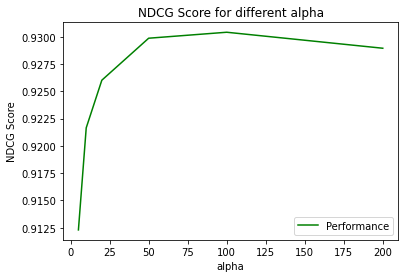

In [55]:
x = alpha
y = ndcg
plt.plot(x, y, 'g', label='Performance')
plt.title('NDCG Score for different alpha')
plt.xlabel('alpha')
plt.ylabel('NDCG Score')
plt.legend()
plt.show()

**Our knn performed very well, lot better then NB.For k=100 we get a score of 0.93. Let's apply other models**

***Linear SVM***

In [56]:
from sklearn.linear_model import SGDClassifier
from tqdm import tqdm
ndc=[]
alpha = [10 ** x for x in range(-3, 3)]
for i in alpha:
    sgd_svm = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=92)
    sgd_svm.fit(X_train,y_train)
    prob_sgd_svm = knn.predict_proba(X_test)
    score_sgd_svm = ndcg_score(y_test, prob_knn, k=5)
    print("For alpha : {}".format(i))
    print("NDCG score : {}".format(score_sgd_svm))
    ndc.append(score_sgd_svm)

For alpha : 0.001
NDCG score : 0.9289410519006862
For alpha : 0.01
NDCG score : 0.9289410519006862
For alpha : 0.1
NDCG score : 0.9289410519006862
For alpha : 1
NDCG score : 0.9289410519006862
For alpha : 10
NDCG score : 0.9289410519006862
For alpha : 100
NDCG score : 0.9289410519006862


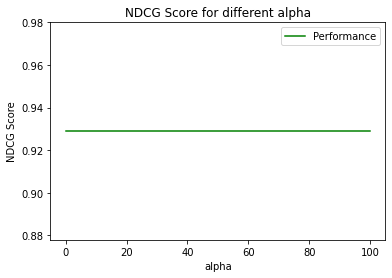

In [59]:
x = alpha
y = ndc
plt.plot(x, y, 'g', label='Performance')
plt.title('NDCG Score for different alpha')
plt.xlabel('alpha')
plt.ylabel('NDCG Score')
plt.legend()
plt.show()

**From Linear SVM too results are similar to knn.**

***Logistic Rrgression with RandomizedSearch***

In [ ]:
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
params =  {'C':[0.0001, 0.001, 0.01]}

lr = linear_model.LogisticRegression(multi_class="multinomial")

clf = RandomizedSearchCV(lr, params, verbose=10, n_iter=3 ,n_jobs=-1,scoring=ndcg_scorer)
clf.fit(X_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


RandomizedSearchCV(estimator=LogisticRegression(multi_class='multinomial'),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'C': [0.0001, 0.001, 0.01]},
                   scoring=make_scorer(ndcg_score, needs_proba=True, k=5),
                   verbose=10)

In [ ]:
pred_y = clf.predict_proba(X_test)
clf.best_params_

{'C': 0.01}

In [ ]:
#Train ndcg score

s = ndcg_score(y_test, pred_y, k=5)

s

0.9357230751227971

***Our Logistic regression gives best result for c=0.01 with score 0.935***

In [ ]:
from sklearn.tree import DecisionTreeClassifier

params = {
'max_depth':[1,2,4,5,6],
'min_samples_split':[5,10,50,100]
}

dt = DecisionTreeClassifier()

clf = RandomizedSearchCV(dt, params, verbose=10,n_jobs=-1,scoring=ndcg_scorer)
clf.fit(X_train,y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [1, 2, 4, 5, 6],
                                        'min_samples_split': [5, 10, 50, 100]},
                   scoring=make_scorer(ndcg_score, needs_proba=True, k=5),
                   verbose=10)

In [ ]:
pred_y = clf.predict_proba(X_test)
clf.best_params_

{'min_samples_split': 5, 'max_depth': 4}

In [ ]:
s = ndcg_score(y_test, pred_y, k=5)
s

0.9359718335664423

***For decision tree best score is obtained at depth 4 and minimum sample split of 5, 0.935***

In [ ]:
from sklearn.ensemble import RandomForestClassifier
params = {
'n_estimators' : [200, 700, 800, 1000, 1200],
'max_depth' : [15, 20, 25, 30, 35, 50] }

rf = RandomForestClassifier()
clf = RandomizedSearchCV(xgb, params, verbose=10,n_jobs=-1,scoring=ndcg_scorer)
clf.fit(X_train,y_train)
        

Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomizedSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'n_estimators' : [200, 700, 800, 1000, 1200],
                   'max_depth' : [15, 20, 25, 30, 35, 50] }
                   scoring=make_scorer(ndcg_score, needs_proba=True, k=5),
                   verbose=10)


In [ ]:
pred_y = clf.predict_proba(X_test)
clf.best_params_


{'max_depth': 4, 'n_estimator': 10}


In [ ]:

s = ndcg_score(y_test, pred_y, k=5)
s

0.8254369072607753


***Random Forest gives lowest score after Naive Bayes among our models with best value of 0.825***

In [ ]:
from xgboost import XGBClassifier
from tqdm import tqdm
n_estimator= [5,10,50,100] 
max_depth= [1,2,3,4]       
xgb = XGBClassifier()
clf = RandomizedSearchCV(xgb, params, verbose=10,n_jobs=-1,scoring=ndcg_scorer)
clf.fit(X_train,y_train)
        

Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomizedSearchCV(estimator=XGBClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [1,2,3,4],
                                        'n_estimator': [5, 10, 50, 100]},
                   scoring=make_scorer(ndcg_score, needs_proba=True, k=5),
                   verbose=10)


In [ ]:
pred_y = clf.predict_proba(X_test)
clf.best_params_

{'max_depth': 1, 'n_estimator' : 100}


In [ ]:

s = ndcg_score(y_test, pred_y, k=5)

s


0.9372843247428133


***Our XgBoost gave best results for max_depth 1 and no of estimators 100.***

***Comparing our Model Scores***

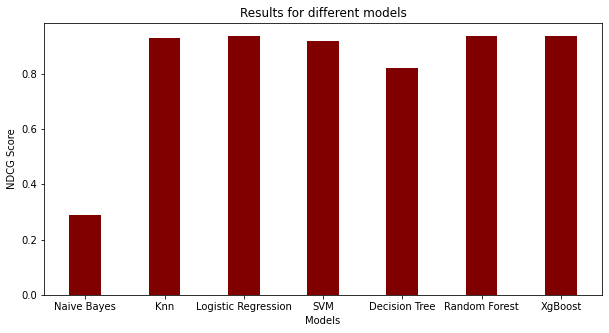

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10, 5))
model=['Naive Bayes','Knn','Logistic Regression','SVM','Decision Tree','Random Forest','XgBoost']
ndcg=[0.29,0.929,0.935,0.92,0.82,0.935,0.937]
# creating the bar plot
plt.bar(model[0:7], ndcg, color ='maroon',
        width = 0.4)
 
plt.xlabel("Models")
plt.ylabel("NDCG Score")
plt.title("Results for different models")
plt.show()

***Best results are obtained from Xgboost.***

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "NDCG Score"]
x.add_row([ 'NB',0.29])
x.add_row([ 'KNN',0.929])
x.add_row([ 'Logistic Regression',0.935])
x.add_row([ 'SVM',0.929])
x.add_row([ 'Random Forest',0.82])
x.add_row([ 'Decision Trees',0.935])
x.add_row([ 'XGBOOST',0.937])
print(x)

+---------------------+------------+
|        Model        | NDCG Score |
+---------------------+------------+
|          NB         |    0.29    |
|         KNN         |   0.929    |
| Logistic Regression |   0.935    |
|         SVM         |   0.929    |
|    Random Forest    |    0.82    |
|    Decision Trees   |   0.935    |
|       XGBOOST       |   0.937    |
+---------------------+------------+


In [60]:
from xgboost import XGBClassifier
     
xgb = XGBClassifier(max_depth=1, n_estimators=100)
xgb.fit(X_tr,y_tr)

XGBClassifier(max_depth=1, objective='multi:softprob')

In [62]:
#
final=xgb.predict_proba(final_test)
#Considering the 5 classes with highest probabilities of destination country
from sklearn import preprocessing 
test_id = list(test.user_id)
ids = []
countries = []
for i in range(len(test_id)):
    idx = test_id[i]
    ids += [idx] * 5
    countries += label_encoder.inverse_transform(np.argsort(final[i])[::-1])[:5].tolist()
#Generating final output file
res = pd.DataFrame(np.column_stack((ids, countries)), columns=['id', 'country'])
res.head()

,id,country
0,5uwns89zht,NDF
1,5uwns89zht,US
2,5uwns89zht,ES
3,5uwns89zht,NL
4,5uwns89zht,IT
